<a href="https://colab.research.google.com/github/Abhijith-Nagarajan/CS_546_Project/blob/feature%2Fquery-classification%2Fllm-based/models/Query_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [ ]:
!pip3 install datasets

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

<h3> Installing the required libraries </h3>

<p>
    package_directory = r'/content/drive/MyDrive/CS_546_Project_Dependencies/lib/python3.10/site-packages' <br>
    <ol>
        <li> !pip install virtualenv </li>
        <li> !pip install scispacy --target=$package_directory </li>
        <li> !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz --target=$package_directory </li>
        <li> !pip install groq --target=$package_directory </li>
    </ol>

Setting the virtual environment:<br>
import virtualenv <br>
!virtualenv /content/drive/MyDrive/CS_546_Project_Dependencies <br>
!source /content/drive/MyDrive/CS_546_Project_Dependencies/bin/activate
</p>




#### Installing packages

In [ ]:
package_directory = r'/content/drive/MyDrive/CS_546_Project_Dependencies/lib/python3.10/site-packages'

In [ ]:
!pip install scispacy --target=$package_directory

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz --target=$package_directory

In [ ]:
!pip install groq --target=$package_directory

In [ ]:
!pip install langchain --target=$package_directory

In [ ]:
!pip install langchain-groq --target=$package_directory

#### Importing libraries

In [1]:
import sys
sys.path.append("/content/drive/MyDrive/CS_546_Project_Dependencies/lib/python3.10/site-packages")

In [2]:
import pandas as pd
import numpy as np
import re
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from spacy import displacy

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [4]:
import en_core_sci_md

In [5]:
from langchain.chains import LLMChain
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate,MessagesPlaceholder
from langchain_core.messages import SystemMessage
from langchain_groq import ChatGroq

In [6]:
from groq import Groq

In [ ]:
#nlp = spacy.load('en_core_web_sm')

In [7]:
nlp = spacy.load('en_core_sci_md')

/usr/local/lib/python3.10/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


### Manipulating the dataset

In [8]:
bioasq_dataset = pd.read_json('training12b_new.json')

In [9]:
def get_required_fields(item: dict):
    try:
        question = item['body']
        question_type = item['type']
    except:
        return 'Error: Could not find body or type'
    return [question, question_type]

In [10]:
df = bioasq_dataset.questions.map(lambda item: get_required_fields(item))

In [11]:
df = pd.DataFrame(df.tolist(), columns=['question', 'question_type'])

In [12]:
for q_type in df.question_type.unique():
    print(f'Processing {q_type}')
    q = df[df.question_type==q_type].sample(5)
    print(q,"\n")

Processing summary
                                               question question_type
1872                        What is adhesive capsulitis       summary
4986                   What is the use of darolutamide?       summary
1403  Which is the localization of the RIFIN family ...       summary
1269  Which is the molecular function of the protein...       summary
3105    What is the mechanism of action of cariprazine?       summary 

Processing list
                                               question question_type
4816  What are the major thrombotic complications in...          list
3409            Which tissues express the ACE2 protein?          list
123   Which genes have been associated with Cerebral...          list
4515  Which small molecules inhibit the c-Myc/Max di...          list
657   List all reported treatment options for anxiet...          list 

Processing yesno
                                               question question_type
993   Are there clinical trials us

In [13]:
def get_query_doc_root(query: str) -> tuple:
    document = nlp(query)
    root_token = [token for token in document if token.dep_ == "ROOT"][0]

    return (document, root_token)

In [14]:
result = df['question'].apply(lambda query: get_query_doc_root(query))

In [15]:
df['document'] = result.apply(lambda tup: tup[0])
df['root_token'] = result.apply(lambda tup: tup[1])

In [ ]:
df['document'][0]

Is Hirschsprung disease a mendelian or a multifactorial disorder?

<h3> 📢Goal - Perform binary classification to assess whether a query is strongly extractive or not. </h3>

<b> 💡Compute the following metrics for each query and map the 4 original categories to be either 0 or 1, with 1 implying strongly extractive.</b>  

### Heuristics to identify nature of query

1. Query keywords and length
    1. Absence of hypothetical knowledge or actionable terms
    2. Absence of subordinate clauses
    3. Coreference and Anaphora
2. Dependency Depth - Dependency Parsing
3. Number of entities and types of entities
4. Relation to prior knowledge/assumption




#### Topic 1: (A) Query Keywords

In [ ]:
sentence = "What gene is response for cancer?"
print('True') if 'response cancer' in sentence else print('False')

False


In [ ]:
def extract_keywords(document: spacy.tokens.doc.Doc, factual_keywords: list = None, query_keywords: list = None,
                     hypothetical_keywords: list = None) -> bool:
    '''
    The objective of this function is to analyze the query for the following keywords which indicate a strong extractive query.

    Strong indicators - For all these categories - Return True:
        (A) Factual Keywords - List, Define, Name, Identify
        (B) Query Keywords - Where, When, Who
        (C) Absence of Hypothetical keywords - Could, Would, Should, Might, If
        (D) Superlative keywords - most, best, worst, highest, lowest

    Requires additional heuristics - Return False:
        (A) Yes/No questions - Is, Does, Are, Can
        (B) Query Keywords - What is, Which, How does (+H)

    '''
    if factual_keywords is None:
        factual_keywords = ['list', 'define', 'name', 'identify','find']

    if query_keywords is None:
        query_keywords = ['what is', 'what are', 'which is', 'which are','where','when']

    if hypothetical_keywords is None:
        hypothetical_keywords = ['could','would','should','can','might','suppose','assume']

    if any(keyword in document.text.lower() for keyword in factual_keywords) or (keyword in factual_keywords for keyword in document.text.lower()):
        return True
    else:
         return False


#### Topic 2: Dependency Parsing
<p> Sample questions to try: <br>
    <ol>
        <li> Which are the mammalian orthologs of Drosophila Yki? </li>
        <li> Is the BAGEL algorithm used for arrayed CRISPR screens?</li>
        <li> Which is the  subcellular localization of ERAP2?</li>
        <li> Which histone modifications have been associated to alternative splicing?</li>
        <li> What role might diet play in influencing gene expression associated with metabolic diseases? </li>
        <li> How could prolonged antibiotic use impact gut microbiota diversity, and what are the potential health consequences?</li>
    </ol>
</p>

##### Computing dependency depth

def compute_depth(root_token: spacy.tokens.token.Token) -> int:
    total_depth = get_depth(root_token)
    return total_depth

In [ ]:
def get_depth(root_token: spacy.tokens.token.Token) -> int:
    if not list(root_token.children):  # No children implies a leaf node
        return 1
    return 1 + max(get_depth(child) for child in root_token.children)

In [ ]:
def display_dependency_depth(document: spacy.tokens.doc.Doc, root_token: spacy.tokens.token.Token, figsize: tuple):
    displacy.render(document, style='dep', jupyter=True, options={'distance': 120})

    # Plot dependency graph
    G = nx.DiGraph()
    layers = {}
    # Add nodes and edges based on dependency structure
    for token in document:
        G.add_node(token.text)
        if token.dep_ != "ROOT":  # If not root, add edge from head to child
            G.add_edge(token.head.text, token.text)

    for token in document:
        layers[token.text] = nx.shortest_path_length(G, source=root_token.text, target=token.text)

    pos = nx.spring_layout(G, k=1, seed=42)  # Initial layout

    # Adjust y-coordinates to reflect layers for vertical layout
    for node, (x, y) in pos.items():
        pos[node] = (x, -layers[node])

    plt.figure(figsize=figsize)
    nx.draw(G,pos,with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
    plt.title("Dependency Tree (Vertical Layout)")
    plt.show()

In [ ]:
df['dependency_depth'] = df['root_token'].apply(lambda root: get_depth(root))

In [ ]:
df['dependency_depth'].value_counts()

,count
dependency_depth,
4,1982
3,1623
5,826
2,333
6,217
7,53
8,9
9,5
10,1


In [ ]:
df_higher_depth = df[df['dependency_depth']>7]

In [ ]:
df_higher_depth.head()

,question,question_type,dependency_depth
352,Are there studies representing the involvement...,yesno,10
790,Is recommended the use of perioperative treatm...,yesno,9
1051,What is the name of the stem loop present in t...,factoid,9
1435,What is the idea behind the fractal globule th...,summary,9
1694,Patients of which disease could be treated by ...,factoid,9


In [ ]:
df_higher_depth.question_type.value_counts()

,count
question_type,
yesno,5
factoid,5
list,4
summary,1


In [ ]:
df_higher_depth[df_higher_depth.question=="Are there studies representing the involvement of Notch mutations in neurodegenerative diseases such as Down syndrome, Pick's and Prion's disease, and cadasil syndrome?"]

,question,question_type,dependency_depth
352,Are there studies representing the involvement...,yesno,10


In [ ]:
df[df.question=='Is alternative splicing of apoptotic genes playing a role in the response to DNA or mitochondrial damage?']
# When using normal spaCy, the dependency depth was 12. After using scispaCy, the depth is 7.

,question,question_type,dependency_depth
300,Is alternative splicing of apoptotic genes pla...,yesno,7


In [ ]:
document = nlp('Is alternative splicing of apoptotic genes playing a role in the response to DNA or mitochondrial damage?')
root_token = [token for token in document if token.dep_ == "ROOT"][0]
total_depth = get_depth(root_token)

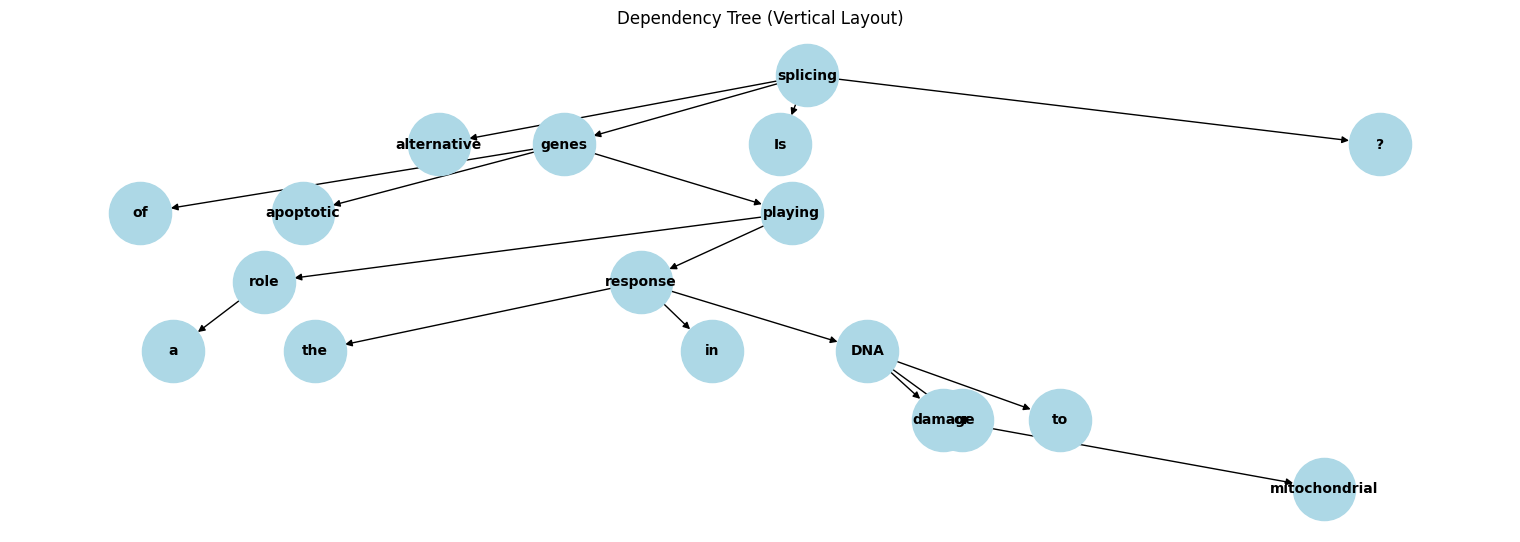

In [ ]:
display_dependency_depth(document, root_token,(15,5))

#### Topic 3: Extracting Total And Types of Entities

In [ ]:
def get_entities(document: spacy.tokens.doc.Doc) -> tuple:
    entities = [(ent.text, ent.label_) for ent in document.ents]

    # Calculate total entities and unique types
    total_entities = len(entities)
    unique_entity_types = len(set(ent[1] for ent in entities))

    return (total_entities,unique_entity_types)

In [ ]:
entities = df['document'].apply(lambda doc: get_entities(doc))

In [ ]:
df['total_entities'] = entities.apply(lambda tup: tup[0])
df['unique_entity_types'] = entities.apply(lambda tup: tup[1])

#### Topic 4: Presence of hypothetical knowledge or actionable terms

### Building the LLM model

In [16]:
groq_api_key = "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" # Replace with environment variable

In [17]:
model = 'mixtral-8x7b-32768'

In [18]:
groq_model = ChatGroq(
    api_key = groq_api_key,
    model = model,
    temperature = 0.25)

In [19]:
conversational_memory_length = 5

In [20]:
memory = ConversationBufferWindowMemory(k=conversational_memory_length, memory_key="chat_history", return_messages=True)

<ipython-input-20-32c26733c201>:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferWindowMemory(k=conversational_memory_length, memory_key="chat_history", return_messages=True)


Old Prompt: <br>
The goal is to take a user query as input and return whether it can considered as strongly extractive (1) or not (0).
Factor in the total length of query, number of entities, and dependency depth to decide.
Additionally, also consider these keyword markers provided below.
For instance: <br><br>
For all these categories - Return 1: <br>
(A) Presence of:
    (1) Factual Keywords - List, Define, Name, Identify etc
    (2) Query Keywords - Where, When, Who
    (3) Superlative keywords - most, best, worst, highest, lowest etc
(B) Absence of Hypothetical keywords - Could, Would, Should, Might, If etc

Requires additional heuristics - Return 0 or 1 case by case:
(A) Yes/No questions - Is, Does, Are, Can etc
(B) Query Keywords - What is, Which, How does etc

Keep this as a base, but note that it might not be entirely accurate. The weightage for each factor is dynamic.
<br><br>
<hr>
New Prompt: <br>
The task is to determine whether a user query is strongly extractive (1) or not extractive (0) based on the following factors. Use the criteria below to make the classification:

Primary Decision Factors:

Query Length: Short, concise queries may lean toward extractive.
Number of Entities: Queries with multiple distinct entities might indicate a need for precise, factual extraction.
Dependency Depth: High dependency depth often implies complexity, suggesting an inference-based query.
Keyword Markers:

Indicators of Strongly Extractive Queries (Return 1):

Factual Keywords: Presence of words like List, Define, Name, Identify.
Direct Query Keywords: Terms such as Where, When, Who suggest a request for specific information.
Superlative Terms: Words like most, best, worst, highest, lowest indicate a focus on specific factual ranking or quantity.
Absence of Hypothetical Language: Avoid words like Could, Would, Should, Might, If, as these suggest speculation or inference rather than fact retrieval.
Conditional Cases (0 or 1 based on context):

Yes/No Questions: Queries starting with Is, Does, Are, Can may or may not be extractive, depending on their specificity.
Complex Queries: Queries beginning with What is, Which, How does may require additional context to determine extractiveness accurately.
Additional Notes:

These rules are flexible; apply weight to each factor dynamically depending on the query’s context.
Use the above criteria as a guideline but exercise judgment for edge cases.

In [21]:
base_message = '''
                The task is to determine whether a user query is strongly extractive (1) or not extractive (0) based on the following factors. Use the criteria below to make the classification:

                Primary Decision Factors:

                Query Length: Short, concise queries may lean toward extractive.
                Number of Entities: Queries with multiple distinct entities might indicate a need for precise, factual extraction.
                Dependency Depth: High dependency depth often implies complexity, suggesting an inference-based query.
                Keyword Markers:

                Indicators of Strongly Extractive Queries (Return 1):

                Factual Keywords: Presence of words like List, Define, Name, Identify.
                Direct Query Keywords: Terms such as Where, When, Who suggest a request for specific information.
                Superlative Terms: Words like most, best, worst, highest, lowest indicate a focus on specific factual ranking or quantity.
                Absence of Hypothetical Language: Avoid words like Could, Would, Should, Might, If, as these suggest speculation or inference rather than fact retrieval.
                Conditional Cases (0 or 1 based on context):

                Yes/No Questions: Queries starting with Is, Does, Are, Can may or may not be extractive, depending on their specificity.
                Complex Queries: Queries beginning with What is, Which, How does may require additional context to determine extractiveness accurately.
                Additional Notes:

                These rules are flexible; apply weight to each factor dynamically depending on the query’s context.
                Use the above criteria as a guideline but exercise judgment for edge cases.
                '''

In [22]:
memory.chat_memory.add_user_message(base_message)

In [23]:
chat_template = ChatPromptTemplate(
    messages = [
        SystemMessage(content=base_message),
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template("Classify the following query: {query}\n Return ONLY THE label first and then explain. Here is the template: Label: |0 or 1|\n. Explanation goes here"),
    ]
)

In [24]:
classification_chain = LLMChain(
    llm=groq_model,
    prompt=chat_template,
    memory=memory
)

<ipython-input-24-d2bd752654e7>:1: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  classification_chain = LLMChain(


In [25]:
def classify_query(query):
    response = classification_chain.run({"query": query})
    return response

In [27]:
query = "Which autophagy pathway is trigered by the KFERQ motif of cytosolic proteins?"
print("Classification:", classify_query(query))

Classification: Label: |1|

Explanation: This query is strongly extractive. It contains the direct query keyword "Which" and the factual keyword "is triggered". These terms indicate a request for specific information, which is a strong indicator of an extractive query. Additionally, the query focuses on a single entity (the KFERQ motif of cytosolic proteins) and has a low dependency depth, both of which suggest a relatively simple, fact-based query.


In [152]:
memory.clear()

Testing queries: <br>
1) Which autophagy pathway is trigered by the KFERQ motif of cytosolic proteins? <br>
2) How does dabigatran therapy affect aPTT in patients with atrial fibrillation? <br>
3) What are the potential side effects of combining Drug A with Drug B in elderly patients? <br>
4) How does the mutation X in Gene Y influence the progression of Disease Z? <br>
5) How does Lifestyle Factor L affect the efficacy of Treatment T in managing Condition C? <br>

### Testing

In [67]:
response = classification_chain.predict(query=query)

In [68]:
response

'The query "What are the targets of Mosunetuzumab?" can be considered strongly extractive and I would return a 1. Here\'s why:\n\n(A) Presence of:\n1) Factual Keywords - The keyword "are" is a factual keyword.\n2) Query Keywords - The keyword "what" is a query keyword.\n3) Superlative keywords - There are no superlative keywords in this query.\n\n(B) Absence of Hypothetical keywords - There are no hypothetical keywords in this query.\n\nAdditional heuristics:\n\nThe query is not a Yes/No question, so we don\'t need to check for that.\n\nThe query keyword "what" indicates that the user is looking for specific information, in this case, the targets of Mosunetuzumab.\n\nThere is only one entity in the query, which is "Mosunetuzumab".\n\nThe dependency depth of the query is shallow, as it only requires identifying the targets of a single entity.\n\nTherefore, based on the above analysis, the query can be considered strongly extractive.'

In [ ]:
scibert_model = AutoModelForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


##### Testing dependency parsing

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
questions = ['Which are the mammalian orthologs of Drosophila Yki?','Is the BAGEL algorithm used for arrayed CRISPR screens?','Which is the subcellular localization of ERAP2?','Which histone modifications have been associated to alternative splicing?','What role might diet play in influencing gene expression associated with metabolic diseases?','How could prolonged antibiotic use impact gut microbiota diversity, and what are the potential health consequences?','']


In [ ]:
sentence = 'How could prolonged antibiotic use impact gut microbiota diversity, and what are the potential health consequences?'
# 'How could mutations in BRCA1 influence cancer treatment outcomes?'

In [ ]:
sentence2 = 'Is the BAGEL algorithm used for arrayed CRISPR screens?'
#'Which is the subcellular localization of ERAP2?'

In [ ]:
doc = nlp(sentence)

In [ ]:
doc2 = nlp(sentence2)

In [ ]:
from datasets import load_dataset

In [ ]:
for item in bioasq_dataset.questions[:3]:
    question = item['body']
    question_type = item['type']
    print(f'Question: {question}')
    print(f'Question Type: {question_type}\n')

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Question Type: summary

Question: List signaling molecules (ligands) that interact with the receptor EGFR?
Question Type: list

Question: Is the protein Papilin secreted?
Question Type: yesno

